In [ ]:
#dependencies
import json
import pandas as pd
import numpy as np 
import re

In [ ]:
file_dir = '/Users/bkirton/desktop/dataAustin2020/Movies-ETL/resources/'

In [ ]:
with open(f'{file_dir}wikipedia.movies.json', mode='r') as file:
    wiki_movies_raw = json.load(file)

In [ ]:
kaggle_metadata = pd.read_csv(f'{file_dir}movies_metadata.csv')
ratings = pd.read_csv(f'{file_dir}ratings.csv')

In [ ]:
wiki_movies_df = pd.DataFrame(wiki_movies_raw)

In [ ]:
wiki_movies = [movie for movie in wiki_movies_raw 
                if ('Director' in movie or 'Directed by' in movie) 
                and 'imdb_link' in movie
                and 'No. of episodes' not in movie]
len(wiki_movies)

In [ ]:
def clean_movie(movie):
    #create a non destructive copy
    movie = dict(movie)
    alt_titles = {}
    #combine alternate titles into one list
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles)>0:
        movie['alt_titles'] = alt_titles
    #merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    #change column names 
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')

    return movie

In [ ]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]
wiki_movies_df = pd.DataFrame(clean_movies)

In [ ]:
#regex string extraction for imdb links
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))
wiki_movies_df.head()


In [ ]:
#find number of null values in each column
[[column,wiki_movies_df[column].isnull().sum()] for column in wiki_movies_df.columns]

In [ ]:
#remove columns with null values greater than 10%
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [ ]:
box_office = wiki_movies_df['Box office'].dropna()

In [ ]:
#lambda function used to keep code clean 
box_office[box_office.map(lambda x: type(x) != str)]

In [ ]:
box_office[box_office.map(lambda x: ' '.join(x) if type(x) == list else x)]

In [ ]:
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
box_office.str.contains(form_one, flags=re.IGNORECASE).sum()

In [ ]:
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'
box_office.str.contains(form_two, flags=re.IGNORECASE).sum()

In [ ]:
matches_form_one = box_office.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = box_office.str.contains(form_two, flags=re.IGNORECASE)

In [ ]:
box_office = box_office.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)

In [ ]:
box_office.str.extract(f'({form_one}|{form_two})')

In [ ]:
def parse_dollars(s):
    # if s is not a string return NaN
    if type(s) != str:
        return np.nan
    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on',s,flags=re.IGNORECASE):
        # remove dollar sign and "million"
        s = re.sub('\$|\s|[a-zA-Z]','',s)
        # convert to float and multiply by a million
        value = float(s)*10**6
        # return value
        return value
    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on',s,flags=re.IGNORECASE):
        # remove dollar sign and "billion"
        s = re.sub('\$|\s|[a-zA-Z]','',s)
        # convert to float and multiply by a billion
        value = float(s)*10**9
        # return value
        return value
    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)',s,flags=re.IGNORECASE):
        # remove dollar sign and commas
        s = re.sub('\$|,','',s)
        # convert to float
        value = float(s)
        # return value
        return value
    # otherwise return NaN
    else:
        return np.nan

In [ ]:
# extract values from box_office and apply parse_dollars
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
# drop box office column
wiki_movies_df.drop('Box office', axis=1, inplace=True)

In [ ]:
# create budget variable
budget = wiki_movies_df['Budget'].dropna()

In [ ]:
#convert any list to strings
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)

In [ ]:
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE)
budget[~matches_form_one & ~matches_form_two]

In [ ]:
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

In [ ]:
# extract data from budget and apply parse dollars. drop budget column
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [ ]:
# convert lists to strings for release date
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)


In [ ]:
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [ ]:
#extract dates
release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)


In [ ]:
#convert to datetime using pandas
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)


In [ ]:
#convert lists to strings
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)


In [ ]:
#extract values with new pattern
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')


In [ ]:
#convert strings to numeric values
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)


In [ ]:
#save output to dataframe
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)


In [ ]:
#drop running time column
wiki_movies_df.drop('Running time', axis=1, inplace=True)


In [115]:
#clean kaggle data
kaggle_metadata.dtypes


adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [116]:
kaggle_metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [118]:
#drop adult column
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')



In [119]:
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [121]:
kaggle_metadata['video'] == 'True'
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'


In [122]:
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [123]:
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])


In [125]:
ratings.info(null_counts=True)
pd.to_datetime(ratings['timestamp'], unit='s')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

In [126]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')


count    2.602429e+07
mean     3.528090e+00
std      1.065443e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

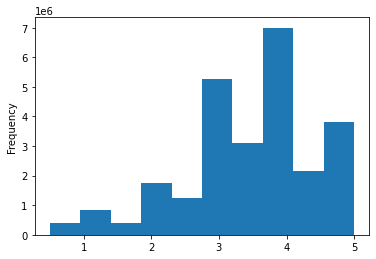

In [127]:
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()